<h1><center>Programming Exercise 3:<br>Multi-class Classification and Neural Networks</center></h1>

In [87]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat 
from scipy.misc import toimage
import random

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Multi-class Classification
- Use Logistic Regression (LogR) and Neural Networks (NN) to recognize hadnwritten digits (from 0 to 9)
- In the first part we will extend our previous implemention of LogR and apply it to one vs all classification

# 1.1 Dataset

In [3]:
# Data set in ex3data1.mat contains 5000 training examples of handwritten digits
# We can load .mat file with scipy.io's loadmat
# it returns a dict with variable names as keys, and loaded matrices as values

loadmat('ex3data1.mat')

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [5]:
data1 = loadmat('ex3data1.mat')
# X is the design matrix of 5000 samples, 400 features for each
# Each sample actually comes from a 20 pixel by 20 pixel image (grayscale) thus comprises a 400-dimensional vector
# y is the output vector with class labels from 1-10; note that the 0 class has been mapped to the number 10 (this is to address an Octave/Matlab issue)
X, y  = data1['X'], data1['y']

## 1.2 Visualizing the Data
- Randomly select 100 rows from X and display this data together as images

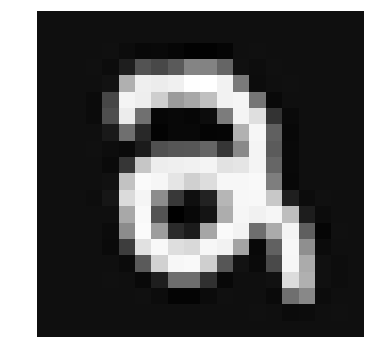

In [129]:
# First let's see how to turn a single sample pixel data into an image
first_sample = X[1111,:]
# Now reshape this into a 20 by 20 2D array
first_sample = np.reshape(first_sample, (20,20))
first_sample = np.flipud(first_sample) # images are upside down so let's flip them
#np.shape(first_sample)

# Can use scipy.misc.toimage to go from numpy array to Python Image Library (PIL) image
first_sample_image = toimage(first_sample) # convert to PIL.Image.Image
first_sample_image = first_sample_image.rotate(270) # Need to rotate them by 270 degrees to get orientation right

# Show image with pyplot.imshow
plt.figure()
plt.imshow(first_sample_image,cmap='Greys_r') # the "_r" bit can reverse any colormap
plt.axis('off')
plt.show()

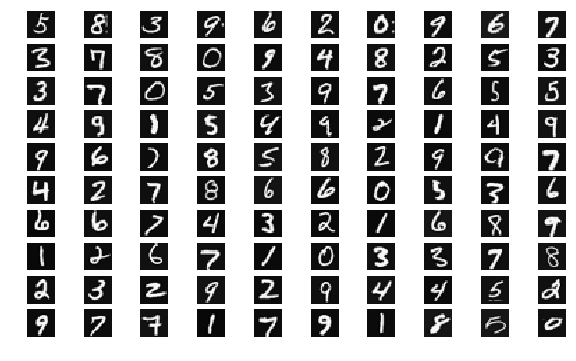

In [132]:
# Select 100 random indices and plot the samples
rand_ind = random.sample(range(0,X.shape[0]),100) # 100 random samples from given population (sequence)

# Save 100 random samples (reshaped into 20 by 20) in array
rand_sample_arr = np.array([np.flipud(np.reshape(X[ii_ind,:],(20,20))) for ii_ind in rand_ind])

# Plot all images as subplots of one figure
plt.figure()
for ii_idx,ii_sample in enumerate(rand_sample_arr):
    ii_image = toimage(ii_sample)
    ii_image = ii_image.rotate(270)
    plt.subplot(10,10,ii_idx+1)
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.show()

## 1.3 Vectorizing Logistic Regression
- Write regularized cost function and gradient descent (GD) functions
- Meat of the work copied over from last week (ex2.ipynb)

In [157]:
def sigmoid(z):
    '''
    Computes the sigmoid function - the hypothesis for Logistic Regression - given input z
    In the case of Logistic Regression z = X*Theta (which is an m by 1 vector)
    so that H = 1/(1+exp(-X*Theta))
    
    Parameters
    ----------
    z: array
    
    Returns
    -------
    value of sigmoid at the given vector z
    '''
    return 1/(1+np.exp(-z))

def costFunction(theta,design,output,reg_param=0):
    '''
    Computes the cost function J = -1/m{Y^T*Log(g(X*Theta))+(1-Y)^T*Log(1-g(X*Theta))}+lambda/2m{Theta^T*Theta}
    which is a function of Theta for a given sample set; the regularization term is included only if a regularization parameter is passed in 
    X is the design matrix of shape m by (n+1), Theta is the fit (n+1) parameter vector, Y is the m output vector of class labels
    and lambda is the regulatization parameter
    Returns the scalar J
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_flag (optional): scalar, regularization parameter; default is 0
    
    Returns
    -------
    costJ: scalar, value of the cost function
    '''
    
    m = np.shape(design)[0] # sample size
    hypothesis = sigmoid(design @ theta)
    costJ = -1/m*(output.T @ np.log(hypothesis)+((1-output).T @ np.log(1-hypothesis)))+reg_param/(2*m)*(theta[1:].T @ theta[1:]) # don't regularize the theta0 parameter

    return costJ

def costFunctionGrad(theta,design,output,reg_param=0):
    '''
    Computes the gradient of the regularized logistic regression cost function 
    J = -1/m{Y^T*Log(g(X*Theta))+(1-Y)^T*Log(1-g(X*Theta))}+lambda/2m{Theta^T*Theta} 
    in vectorized form:
    dJ/dTheta_j = 1/m{X^T*{g(X*Theta)-Y}} + (lambda/m)Theta_j for j=0,1,..,n
    (Note: the 0th term does not get regularized)

    The regularization factor will only be added if a regularization parameter is passed in
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_param: scalar, regularization parameter; default is 0
    
    Returns
    ----------
    gradJ: (n+1) vector of gradient of cost function 
    '''
    m = np.shape(design)[0] # sample size
    hypothesis = sigmoid(design @ theta)

    gradJ = np.empty_like(theta) # allocate space for gradient of cost function     
    gradJ = 1/m*(design.T @ (hypothesis-output)) 
    gradJ[1:] += (reg_param/m)*theta[1:] # regularize all other theta's but not theta_0

    return gradJ

In [158]:
# Testing with values from ex3.m

test_theta = np.array([-2,-1,1,2])
test_design = np.array([[1,0.1,0.6,1.1],[1,0.2,0.7,1.2],[1,0.3,0.8,1.3],[1,0.4,0.9,1.4],[1,0.5,1,1.5]])
test_output = np.array([1,0,1,0,1])
test_reg_param = 3

# Test
test_cost = costFunction(test_theta,test_design,test_output,reg_param=test_reg_param)
test_gradJ = costFunctionGrad(test_theta,test_design,test_output,reg_param=test_reg_param)
print('Expected Cost Function: 2.534819')
print('Computed Cost Function: {}'.format(test_cost))
print('Expected Cost Function Gradients: [0.146561 -0.548558 0.724722 1.398003]')
print('Computed Cost Function Gradients: {}'.format(test_gradJ))

Expected Cost Function: 2.534819
Computed Cost Function: 2.534819396109744
Expected Cost Function Gradients: [0.146561 -0.548558 0.724722 1.398003]
Computed Cost Function Gradients: [ 0.14656137 -0.54855841  0.72472227  1.39800296]


# 1.4 One-vs-All Classification